# Multiple Seasonal data

<hr>

There are many methods to decompose a time series with a <b>single seasonal</b> component, such as <b>STL</b> and <b>X-13-ARIMA-SEATS.</b>

But what about time series which have multiple seasonal components?

Consider electricity demand for example. Electricity demand has daily seasonality (more demand during the day than late at night), weekly seasonality (weekends vs weekdays), and yearly seasonality (demand in the summer and winter differs due to heating and cooling needs).

source: [Multi-Seasonal Time Series Decomposition Using MSTL in Python](https://towardsdatascience.com/multi-seasonal-time-series-decomposition-using-mstl-in-python-136630e67530)

In [1]:
import numpy as np
import pandas as pd
import os, gc
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from mstl import MSTL

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

## Victoria Electricity Demand dataset

<hr>

It is the total electricity demand at a half hourly granularity for the state of Victoria in Australia from 2002 to the start of 2015.

This dataset is used in the [original MSTL paper](https://arxiv.org/pdf/2107.13462.pdf)

In [2]:
source_url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(source_url)

In [3]:
df["Date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

df["Date"] = df["Date"] + pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

In [4]:
train_test = df[["Date", "OperationalLessIndustrial"]]
train_test.columns = ['date', 'electricity_demand']

# filter only from Jan 2013 - Mar 2015
start_date = pd.to_datetime("2013-01-01")
mask_ = (train_test["date"] >= start_date)
train_test = train_test[mask_]

# Resample to hourly
train_test = train_test.set_index("date").resample("H").sum()

# add datetime features
train_test['week'] = train_test.index.isocalendar().week
train_test['month'] = train_test.index.month
train_test['dayname'] = train_test.index.day_name()
train_test['day_of_month'] = train_test.index.day
train_test['hour'] = train_test.index.hour

## Train Test Split

<hr>

In [5]:
train = train_test.loc[:'2014-12-31']
test = train_test.loc['2015-01-01':'2015-02-28']

print('Train date')
print('start:', train.index.min())
print('end:', train.index.max())

print('\nTest date')
print('start:', test.index.min())
print('end:', test.index.max())

Train date
start: 2013-01-01 00:00:00
end: 2014-12-31 23:00:00

Test date
start: 2015-01-01 00:00:00
end: 2015-02-28 23:00:00


## EDA

In [6]:
temp_df = train.groupby(['dayname', 'hour']).electricity_demand.sum().reset_index()
temp_df = temp_df.pivot('dayname', 'hour', 'electricity_demand')
temp_df = temp_df.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

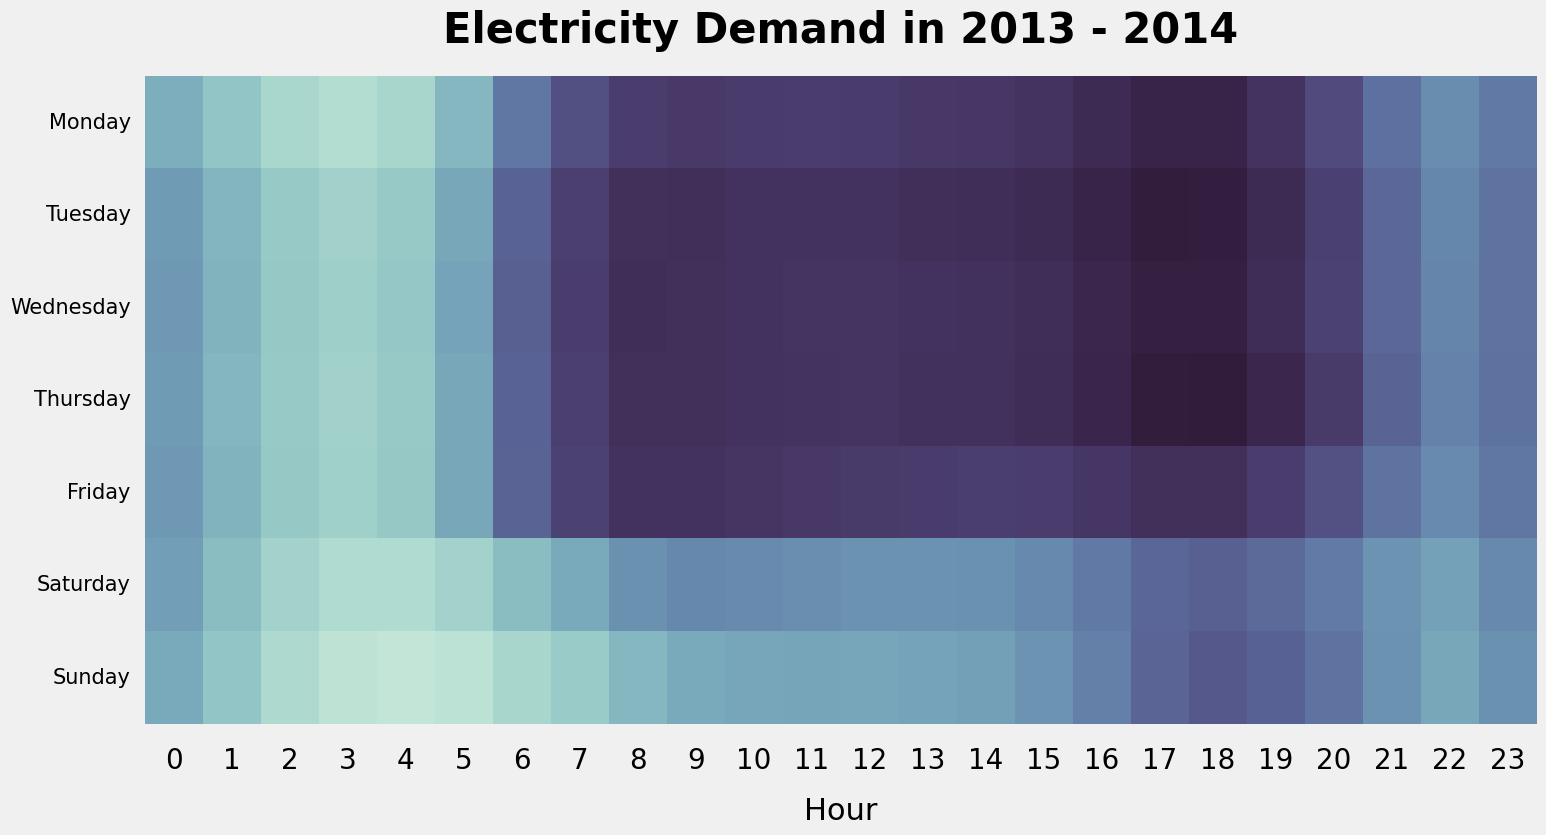

In [7]:
plt.figure(figsize=(16, 8))
cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
sns.heatmap(temp_df, cmap=cmap, cbar=False)

plt.xlabel('Hour', labelpad=16, size=22)
plt.ylabel(None)

plt.title('Electricity Demand in 2013 - 2014', fontsize=30, fontweight='bold', pad=24)
plt.tick_params(axis='x', which='major', labelsize=20, pad=16)
plt.tick_params(axis='y', which='major', labelsize=15, pad=10, rotation=0)

plt.show()

## Pattern

<hr>

- On weekdays, most people started to use electricity from 06:00 till 20:00

- On weekends, electricity consumption is lower because many commercial offices are closed

- The least amount of electricity is consumed at night when most people sleep

<div class="alert alert-warning"> <b>Monday to Thursday has an evening peak at 17:00 - 18:00<br><br>Do you know why?</b> </div>

In [8]:
## --------------------------------------------------------------------------------------------------------------------- ##

# MSTL

MSTL stands for Multiple Seasonal-Trend decomposition using Loess. 

It assumes that the time series can be expressed as an additive decomposition:

<img src="https://miro.medium.com/max/1134/1*aT7P8lBy9BO7SQT-eonwIQ.png" alt="Stationarity" width="600" align="left">

<div class="alert alert-success"> <b>MSTL not only accurate, computationally efficient, robust to outliers<br><br>It also can capture seasonality which changes with time (e.g., the daily pattern of electricity demand will be different in the winter compared to the summer)</b> </div>



In [9]:
# missing data must be handled outside of the MSTL
# periods 24 (daily) and 24*7 (weekly)

mstl = MSTL(train["electricity_demand"].loc['2013-12-01':'2014-02-28'], periods=(24, 24 * 7))
res_summer = mstl.fit() 

## Summer and Winter seasonal pattern

<hr>

According to [australia.com](https://www.australia.com/)

- Summer season: December to February

- Winter season: June to August

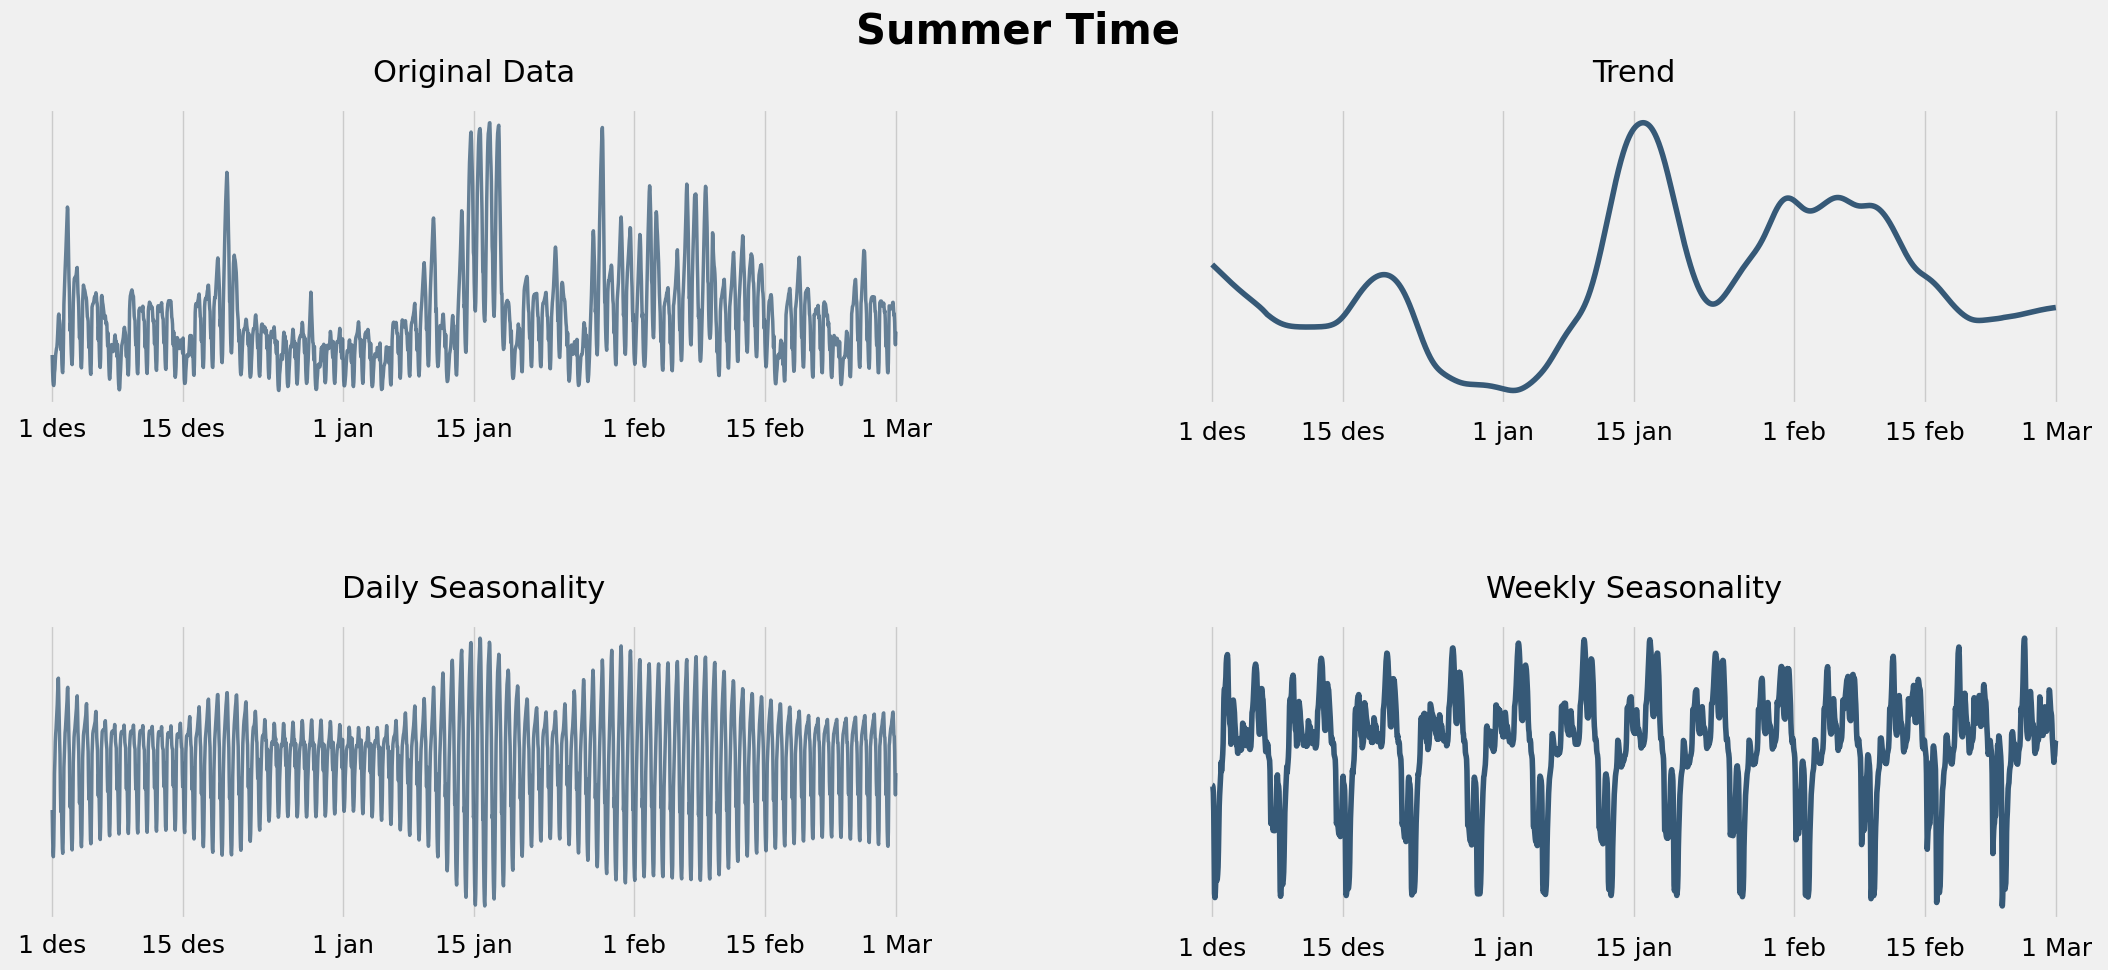

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 10))

ax.ravel()[0].plot(train["electricity_demand"].loc['2013-12-01':'2014-02-28'], color='#365977', alpha=0.75, lw=2.5)
ax.ravel()[0].set_title('Original Data', pad=20, fontsize=22)
ax.ravel()[0].set_xticks(['2013-12-01', '2013-12-15', '2014-01-01', '2014-01-15', '2014-02-01', '2014-02-15', '2014-03-01'], ['1 des', '15 des', '1 jan', '15 jan', '1 feb', '15 feb', '1 Mar'])
ax.ravel()[0].set_yticks([])
ax.ravel()[0].tick_params(axis='x', which='major', labelsize=18, pad=10, rotation=0)

ax.ravel()[1].plot(res_summer.trend, color='#365977')
ax.ravel()[1].set_title('Trend', pad=20, fontsize=22)
ax.ravel()[1].set_xticks(['2013-12-01', '2013-12-15', '2014-01-01', '2014-01-15', '2014-02-01', '2014-02-15', '2014-03-01'], ['1 des', '15 des', '1 jan', '15 jan', '1 feb', '15 feb', '1 Mar'])
ax.ravel()[1].set_yticks([])
ax.ravel()[1].tick_params(axis='x', which='major', labelsize=18, pad=12, rotation=0)

ax.ravel()[2].plot(res_summer.seasonal.seasonal_24, color='#365977', alpha=0.75, lw=2.5)
ax.ravel()[2].set_title('Daily Seasonality', pad=20, fontsize=22)
ax.ravel()[2].set_xticks(['2013-12-01', '2013-12-15', '2014-01-01', '2014-01-15', '2014-02-01', '2014-02-15', '2014-03-01'], ['1 des', '15 des', '1 jan', '15 jan', '1 feb', '15 feb', '1 Mar'])
ax.ravel()[2].set_yticks([])
ax.ravel()[2].tick_params(axis='x', which='major', labelsize=18, pad=10, rotation=0)

ax.ravel()[3].plot(res_summer.seasonal.seasonal_168, color='#365977')
ax.ravel()[3].set_title('Weekly Seasonality', pad=20, fontsize=22)
ax.ravel()[3].set_xticks(['2013-12-01', '2013-12-15', '2014-01-01', '2014-01-15', '2014-02-01', '2014-02-15', '2014-03-01'], ['1 des', '15 des', '1 jan', '15 jan', '1 feb', '15 feb', '1 Mar'])
ax.ravel()[3].set_yticks([])
ax.ravel()[3].tick_params(axis='x', which='major', labelsize=18, pad=12, rotation=0)

plt.suptitle('Summer Time', fontsize=30, fontweight='bold')
plt.subplots_adjust(hspace = 0.75, wspace=.25)
plt.show()

In [11]:
# periods 24 (daily) and 24*7 (weekly)
mstl = MSTL(train["electricity_demand"].loc['2014-06-01':'2014-08-31'], periods=(24, 24 * 7))
res_winter = mstl.fit() 

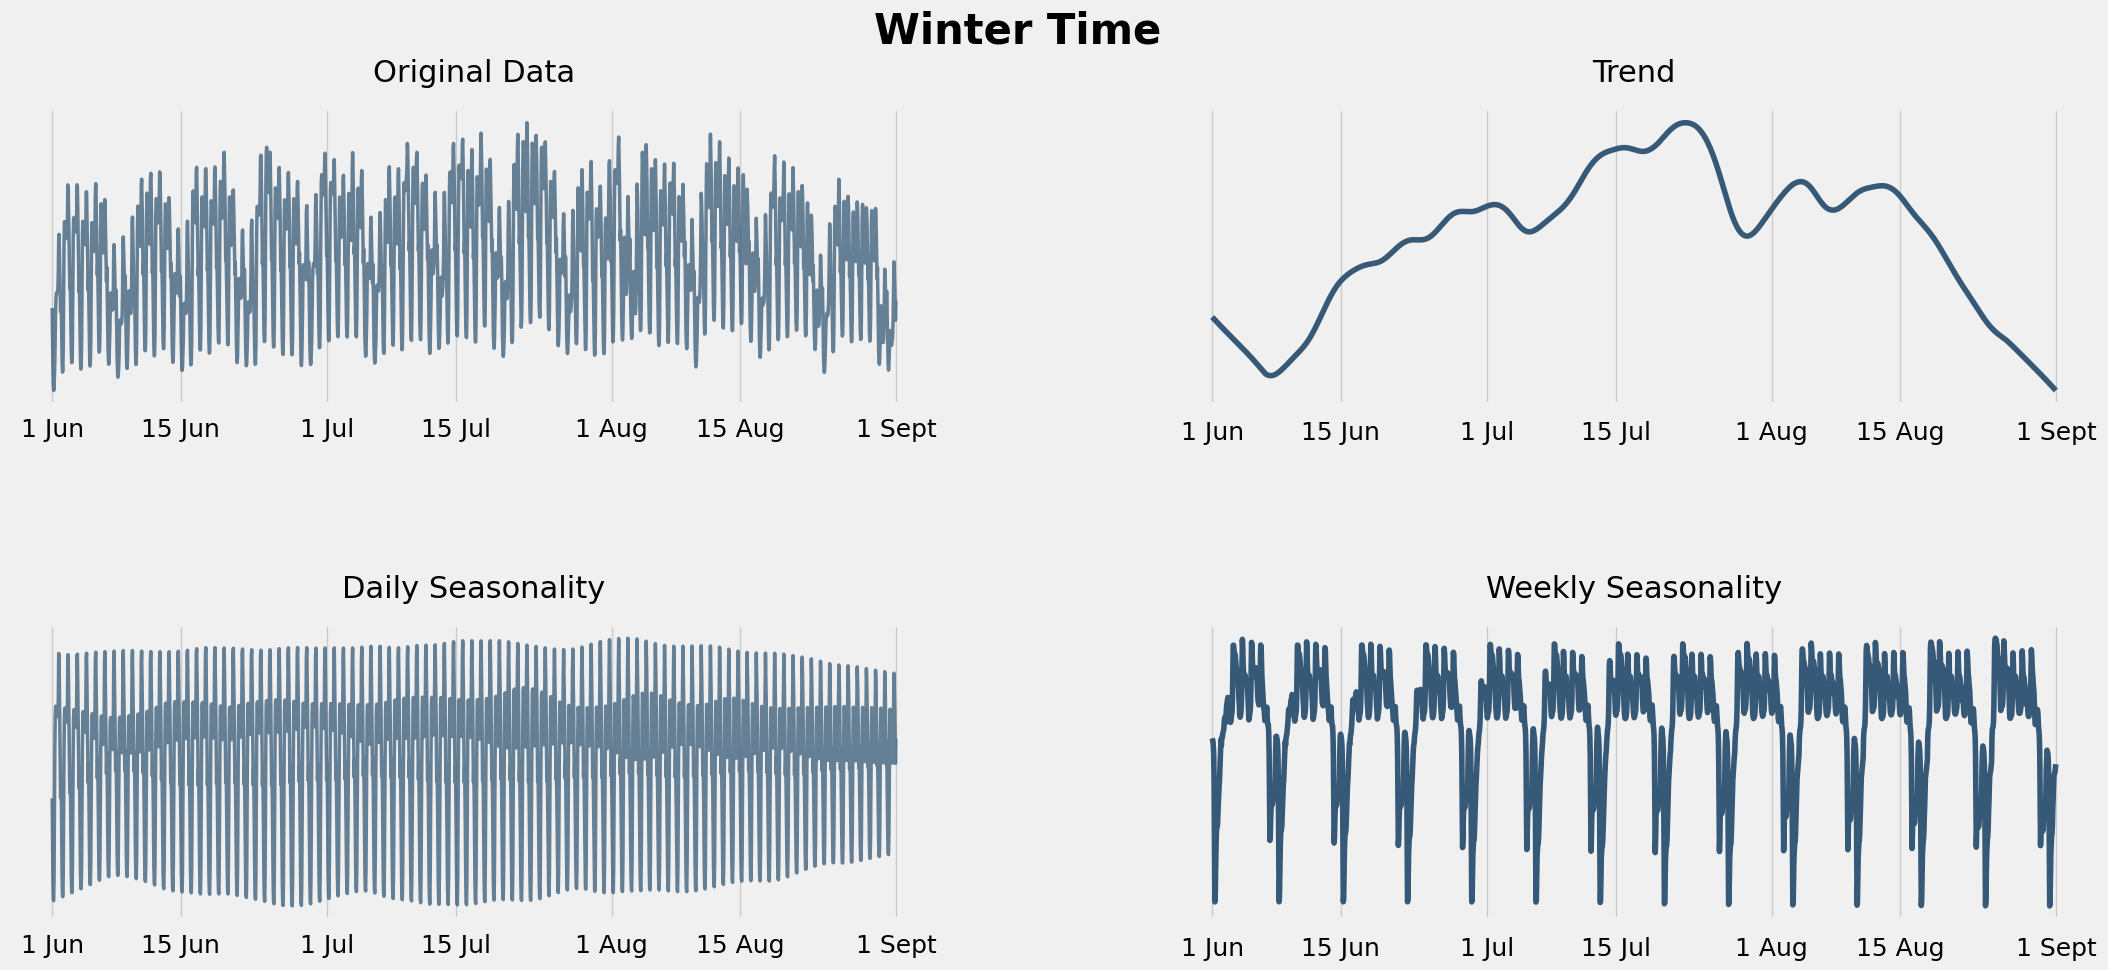

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 10))

ax.ravel()[0].plot(train["electricity_demand"].loc['2014-06-01':'2014-08-31'], color='#365977', alpha=0.75, lw=2.5)
ax.ravel()[0].set_title('Original Data', pad=20, fontsize=22)
ax.ravel()[0].set_xticks(['2014-06-01', '2014-06-15', '2014-07-01', '2014-07-15', '2014-08-01', '2014-08-15', '2014-09-01'], ['1 Jun', '15 Jun', '1 Jul', '15 Jul', '1 Aug', '15 Aug', '1 Sept'])
ax.ravel()[0].set_yticks([])
ax.ravel()[0].tick_params(axis='x', which='major', labelsize=18, pad=10, rotation=0)

ax.ravel()[1].plot(res_winter.trend, color='#365977')
ax.ravel()[1].set_title('Trend', pad=20, fontsize=22)
ax.ravel()[1].set_xticks(['2014-06-01', '2014-06-15', '2014-07-01', '2014-07-15', '2014-08-01', '2014-08-15', '2014-09-01'], ['1 Jun', '15 Jun', '1 Jul', '15 Jul', '1 Aug', '15 Aug', '1 Sept'])
ax.ravel()[1].set_yticks([])
ax.ravel()[1].tick_params(axis='x', which='major', labelsize=18, pad=12, rotation=0)

ax.ravel()[2].plot(res_winter.seasonal.seasonal_24, color='#365977', alpha=0.75, lw=2.5)
ax.ravel()[2].set_title('Daily Seasonality', pad=20, fontsize=22)
ax.ravel()[2].set_xticks(['2014-06-01', '2014-06-15', '2014-07-01', '2014-07-15', '2014-08-01', '2014-08-15', '2014-09-01'], ['1 Jun', '15 Jun', '1 Jul', '15 Jul', '1 Aug', '15 Aug', '1 Sept'])
ax.ravel()[2].set_yticks([])
ax.ravel()[2].tick_params(axis='x', which='major', labelsize=18, pad=10, rotation=0)

ax.ravel()[3].plot(res_winter.seasonal.seasonal_168, color='#365977')
ax.ravel()[3].set_title('Weekly Seasonality', pad=20, fontsize=22)
ax.ravel()[3].set_xticks(['2014-06-01', '2014-06-15', '2014-07-01', '2014-07-15', '2014-08-01', '2014-08-15', '2014-09-01'], ['1 Jun', '15 Jun', '1 Jul', '15 Jul', '1 Aug', '15 Aug', '1 Sept'])
ax.ravel()[3].set_yticks([])
ax.ravel()[3].tick_params(axis='x', which='major', labelsize=18, pad=12, rotation=0)

plt.suptitle('Winter Time', fontsize=30, fontweight='bold')
plt.subplots_adjust(hspace = 0.75, wspace=.25)
plt.show()

## We can see that summer and winter have a different patterns

<hr>

Let's inspect the seasonal components in a bit more detail and look at the first few days and weeks to examine the daily and weekly seasonality.

- One of the advantages of MSTL is that is allows us to capture seasonality which changes over time

- We saw above that the daily seasonality is different in the summer and winter

<div class="alert alert-success"> <b>Let's start with daily seasonality</b> </div>

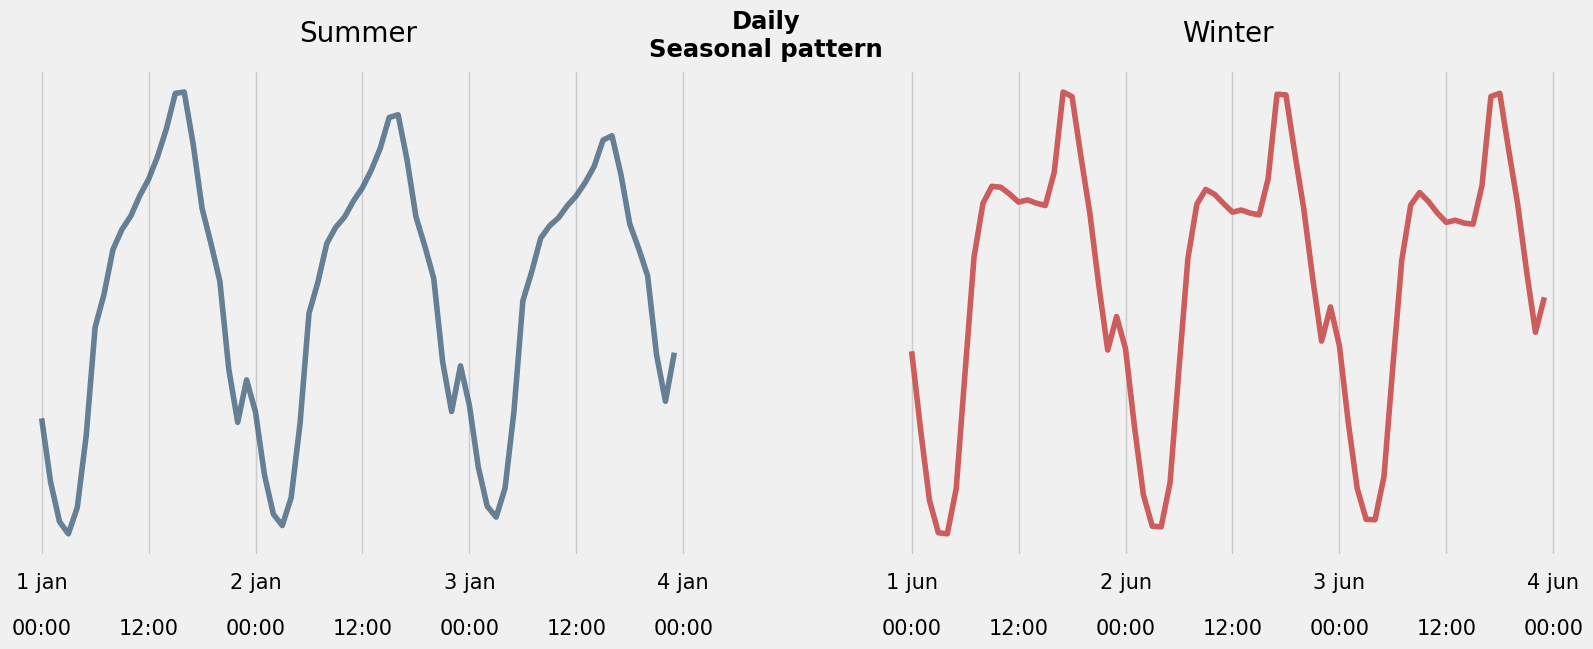

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax.ravel()[0].plot(res_summer.seasonal.seasonal_24.iloc[: 24 * 3], color='#365977', alpha=0.75)
ax.ravel()[0].set_title('Summer', pad=20, fontsize=20)
ax.ravel()[0].set_xticks(['2013-12-01 00:00:00', '2013-12-01 12:00:00', '2013-12-02 00:00:00', '2013-12-02 12:00:00', '2013-12-03 00:00:00', '2013-12-03 12:00:00', '2013-12-04 00:00:00'], ['1 jan\n\n00:00', '\n\n12:00', '2 jan\n\n00:00', '\n\n12:00', '3 jan\n\n00:00', '\n\n12:00', '4 jan\n\n00:00'])
ax.ravel()[0].set_yticks([])
ax.ravel()[0].tick_params(axis='x', which='major', labelsize=15, pad=12, rotation=0)

ax.ravel()[1].plot(res_winter.seasonal.seasonal_24.iloc[: 24 * 3], color='indianred')
ax.ravel()[1].set_title('Winter', pad=20, fontsize=20)
ax.ravel()[1].set_xticks(['2014-06-01 00:00:00', '2014-06-01 12:00:00', '2014-06-02 00:00:00', '2014-06-02 12:00:00', '2014-06-03 00:00:00', '2014-06-03 12:00:00', '2014-06-04 00:00:00'], ['1 jun\n\n00:00', '\n\n12:00', '2 jun\n\n00:00', '\n\n12:00', '3 jun\n\n00:00', '\n\n12:00', '4 jun\n\n00:00'])
ax.ravel()[1].set_yticks([])
ax.ravel()[1].tick_params(axis='x', which='major', labelsize=15, pad=12, rotation=0)

plt.suptitle('Daily\nSeasonal pattern', fontsize=17.5, fontweight='bold')
plt.subplots_adjust(wspace=.25)
plt.show()

<div class="alert alert-success"> <b>Daily seasonality of electricity demand is well captured by MSTL.<br><br>We saw previously that weekends and weekdays have different demand. Let's see if this is picked up in the weekly seasonality.</b> </div>

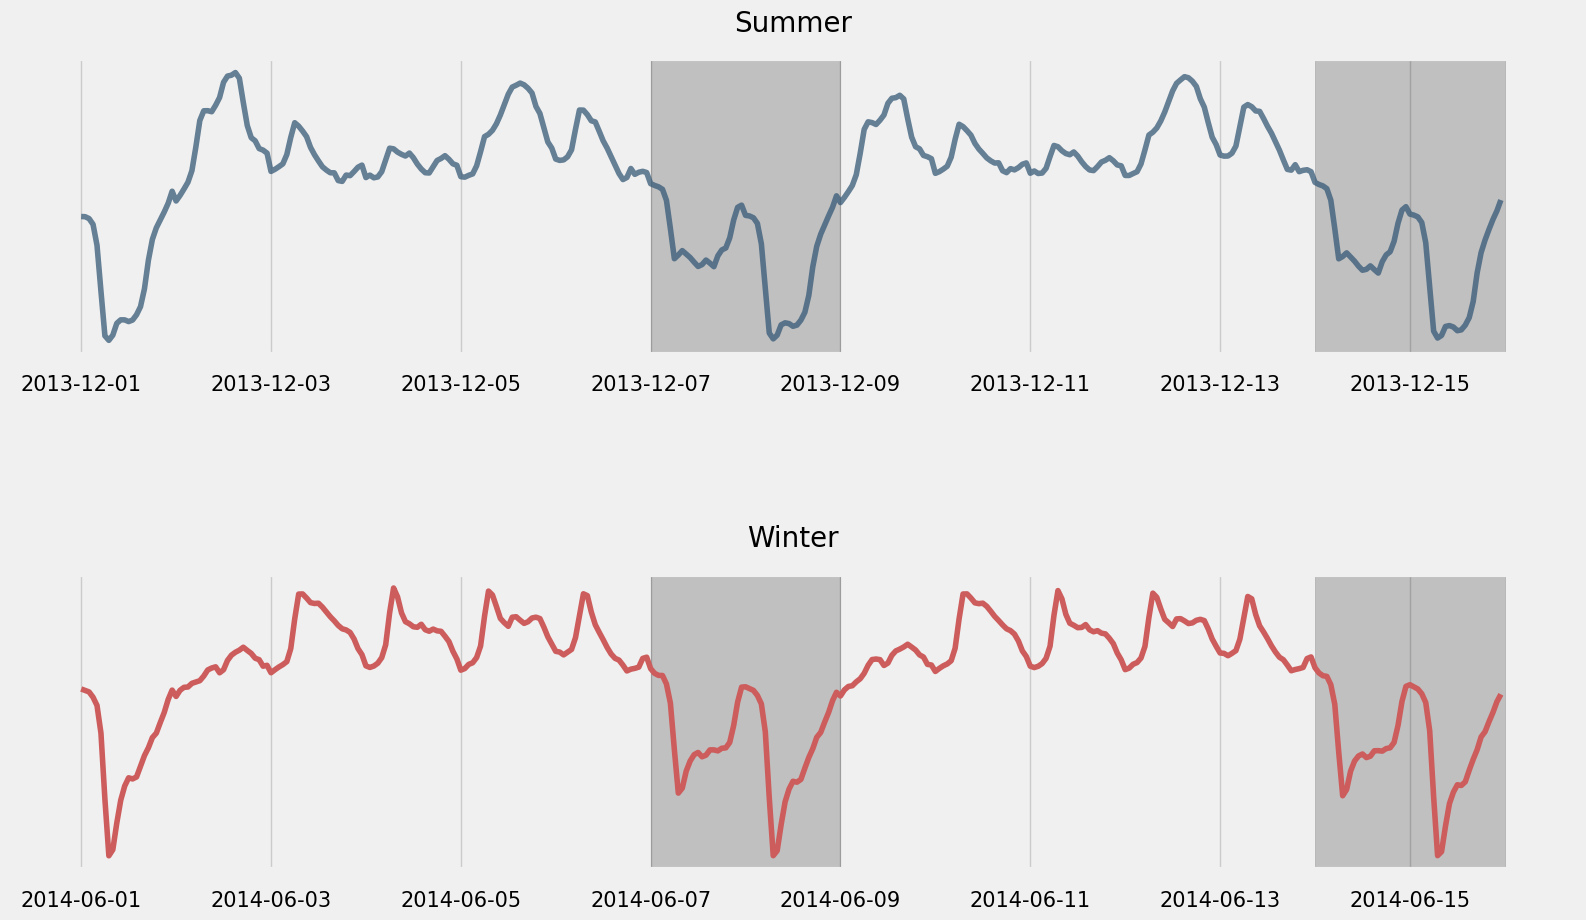

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 10))

ax.ravel()[0].plot(res_summer.seasonal.seasonal_168.iloc[: 24 * 15], color='#365977', alpha=0.75)
ax.ravel()[0].set_title('Summer', pad=20, fontsize=20)
ax.ravel()[0].set_yticks([])
ax.ravel()[0].tick_params(axis='x', which='major', labelsize=15, pad=15, rotation=0)
ax.ravel()[0].axvspan('2013-12-07 00:00:00', '2013-12-09 00:00:00', alpha=0.2, color="black")
ax.ravel()[0].axvspan('2013-12-14 00:00:00', '2013-12-16 00:00:00', alpha=0.2, color="black")

ax.ravel()[1].plot(res_winter.seasonal.seasonal_168.iloc[: 24 * 15], color='indianred')
ax.ravel()[1].set_title('Winter', pad=20, fontsize=20)
ax.ravel()[1].set_yticks([])
ax.ravel()[1].tick_params(axis='x', which='major', labelsize=15, pad=15, rotation=0)
ax.ravel()[1].axvspan('2014-06-07 00:00:00', '2014-06-09 00:00:00', alpha=0.2, color="black")
ax.ravel()[1].axvspan('2014-06-14 00:00:00', '2014-06-16 00:00:00', alpha=0.2, color="black")

plt.subplots_adjust(hspace=.75)
plt.show()

<div class="alert alert-success"> <b>For the weekly seasonality extracted by MSTL we can see that there is less usage during the weekends as expected.<br><br>That's it! Using MSTL we can perform time series decompostion on a multi-seasonal time series!</b> </div>

In [15]:
## --------------------------------------------------------------------------------------------------------------------- ##

# Forecasting

## Facebook Prophet

In [16]:
import logging
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet

logging.getLogger('prophet').setLevel(logging.WARNING)

Importing plotly failed. Interactive plots will not work.


In [17]:
# prepare train test in prophet format
prophet_train = pd.DataFrame()
prophet_test = pd.DataFrame()

prophet_train['ds'] = train.index
prophet_train['y'] = train['electricity_demand'].values
prophet_train['is_weekend'] = ((prophet_train['ds'].dt.day_name() == 'Saturday') | (prophet_train['ds'].dt.day_name() == 'Sunday')).astype(int)

prophet_test['ds'] = test.index
prophet_test['y'] = test['electricity_demand'].values
prophet_test['is_weekend'] = ((prophet_test['ds'].dt.day_name() == 'Saturday') | (prophet_test['ds'].dt.day_name() == 'Sunday')).astype(int)

In [18]:
%%time

# initiate a Prophet model
prophet = Prophet(daily_seasonality=True,
                  # yearly_seasonality=12, # the default Fourier order for yearly seasonality is 10
                  # holidays=holidays,
                  growth='flat', # For time series that exhibit strong seasonality patterns rather than trend changes, it may be useful to force the trend growth rate to be flat.
                  changepoint_prior_scale=0.35,
                  # seasonality_prior_scale=0.5,
                  seasonality_mode='multiplicative', # additive
                  interval_width=0.85, # the width of the uncertainty intervals, by default 0.8
                  changepoint_range=0.9)

prophet.add_regressor('is_weekend', prior_scale=0.35, mode='multiplicative') # additive

prophet.fit(prophet_train)
pred = prophet.predict(prophet_test)['yhat']
pred.index = prophet_test['ds']

23:47:47 - cmdstanpy - INFO - Chain [1] start processing
23:47:47 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 1.81 s
Wall time: 2.3 s


<div class="alert alert-success"> <b>Prophet training time is very fast<br><br>If we use growth='linear', it will take longer, but still less than 20 second</b> </div>

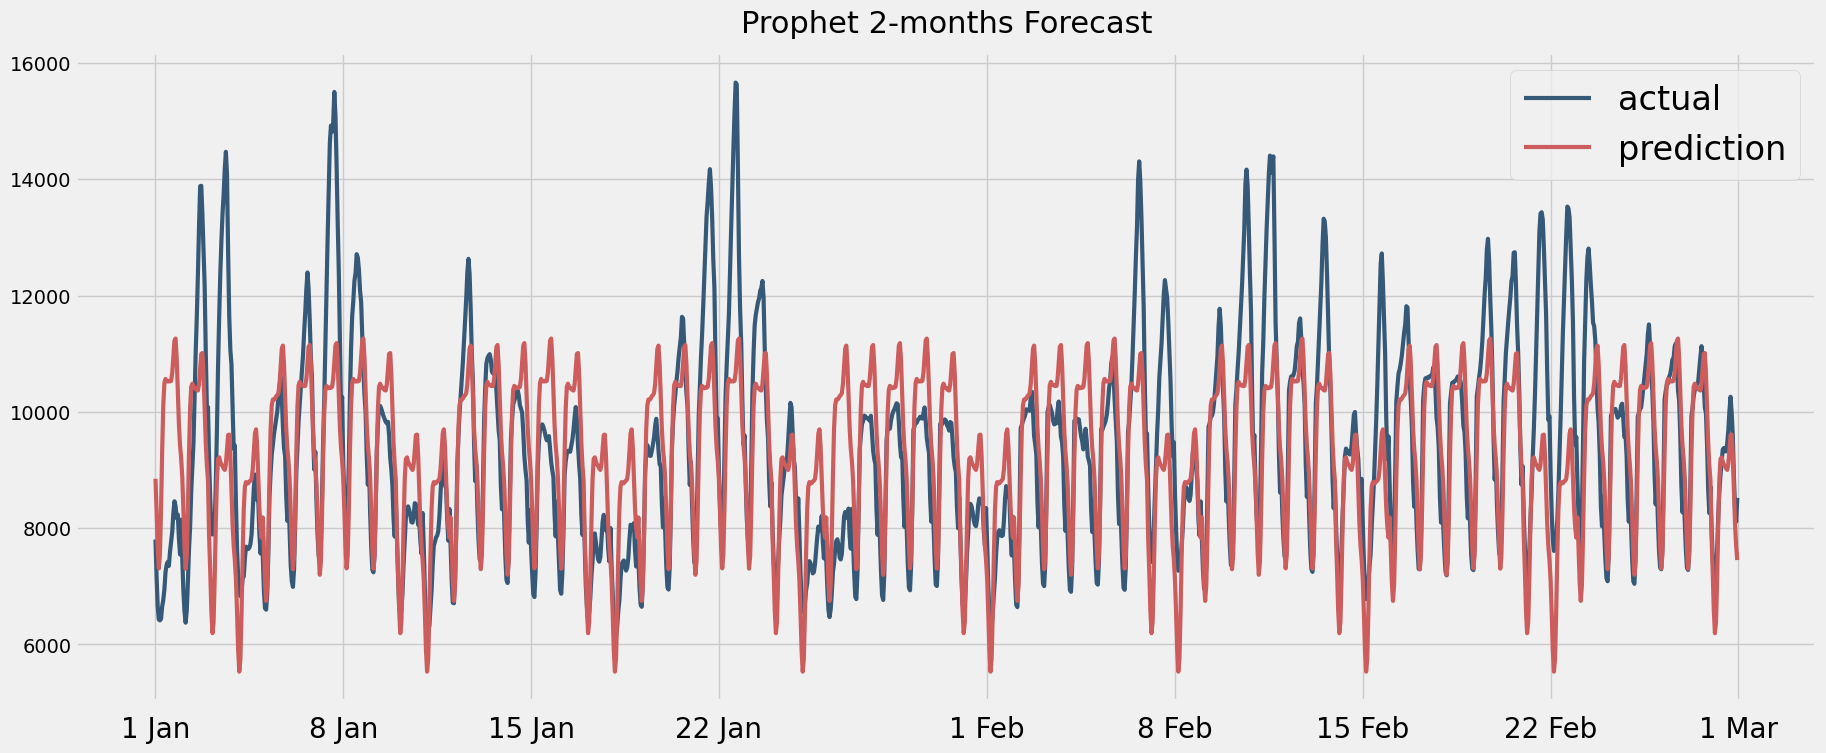

In [19]:
fig = plt.figure(figsize=(20, 8))

plt.plot(prophet_test.set_index('ds')['y'], color='#365977', lw=3, label='actual')
plt.plot(pred, color='indianred', lw=3, label='prediction')

plt.title('Prophet 2-months Forecast', pad=15, fontsize=22)
plt.xticks(['2015-01-01', '2015-01-08', '2015-01-15', '2015-01-22', '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22', '2015-03-01'], ['1 Jan', '8 Jan', '15 Jan', '22 Jan', '1 Feb', '8 Feb', '15 Feb', '22 Feb', '1 Mar'])
plt.tick_params(axis='x', which='major', labelsize=20, pad=10)
plt.legend(fontsize='xx-large')
plt.show()

In [ ]:
## --------------------------------------------------------------------------------------------------------------------- ##

## TBATS

<hr>

TBATS was designed to forecast time series with multiple seasonal periods. For example, hourly data can have three seasonal periods: a daily pattern, a weekly pattern, and an annual pattern.

<br>

TBATS is acronym for:

- Trigonometric seasonality

- Box-Cox transformation

- ARMA errors

- Trend

- Seasonal components

In [20]:
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.base import ForecastingHorizon

# https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.tbats.TBATS.html
forecaster = TBATS(  
    use_box_cox=None,
    use_trend=None,
    use_damped_trend=None, # Applies only when trend is used
    sp=[24, 24 * 7],
    use_arma_errors=False,
    n_jobs=-1)

In [21]:
%%time

# ForecastingHorizon([1, 2, 3], is_relative=True); ['1960-07', '1960-08', '1960-09']
fh_abs = ForecastingHorizon(test.index, is_relative=False)  

forecaster.fit(train[['electricity_demand']])

tbats_pred = forecaster.predict(fh=fh_abs)

CPU times: total: 1min 40s
Wall time: 23min 44s


<div class="alert alert-danger"> <b>One drawback of TBATS models is slow to train<br><br>Especially with long time series dataset</b> </div>

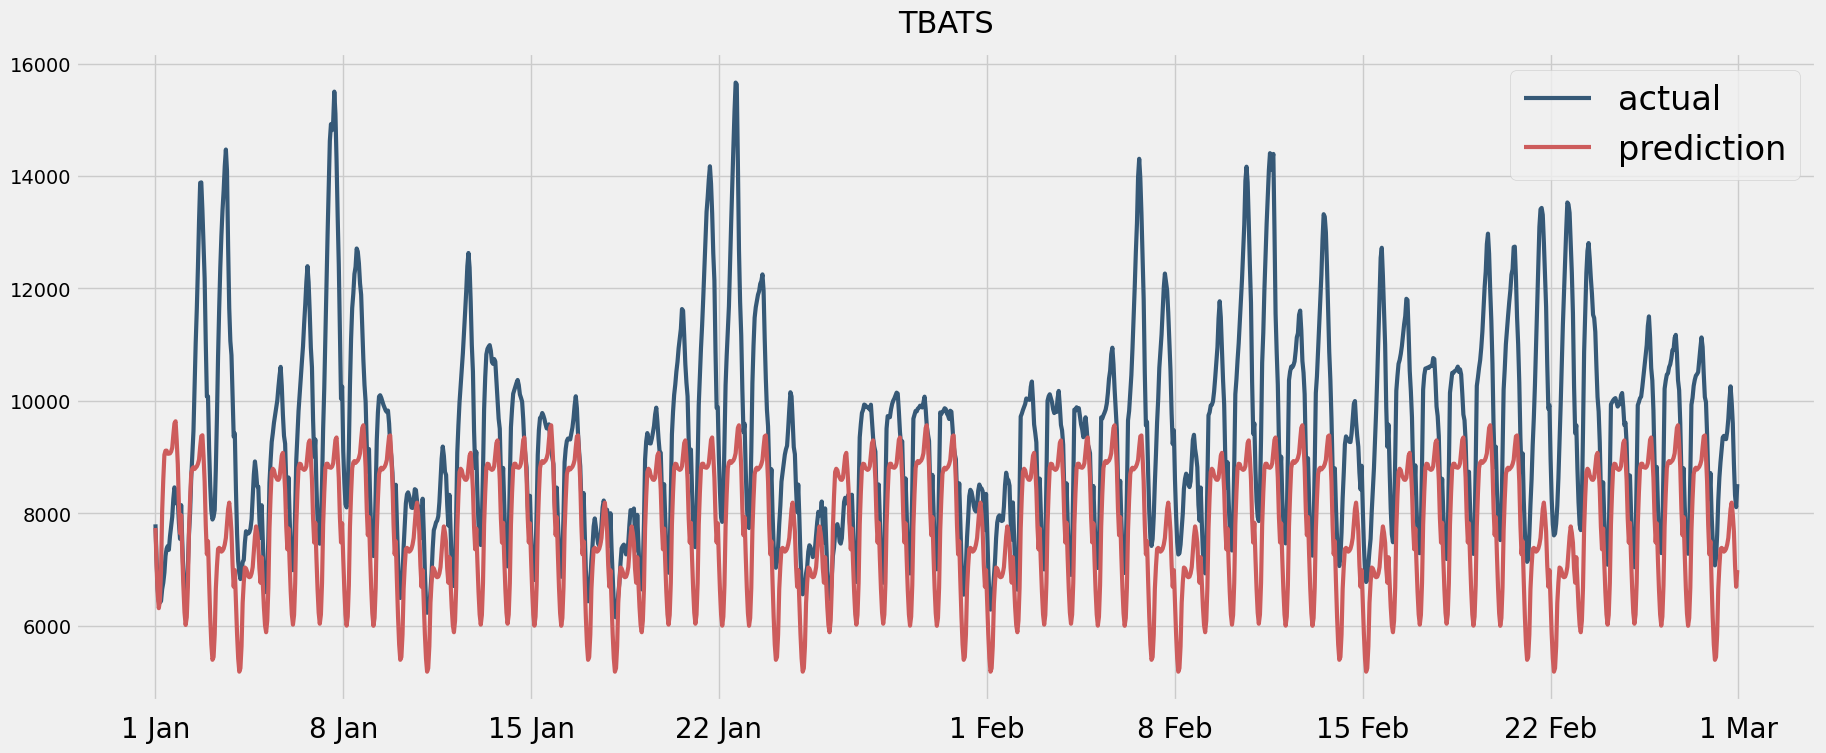

In [22]:
fig = plt.figure(figsize=(20, 8))

plt.plot(test['electricity_demand'], color='#365977', lw=3, label='actual')
plt.plot(tbats_pred, color='indianred', lw=3, label='prediction')

plt.title('TBATS', pad=15, fontsize=22)
plt.xticks(['2015-01-01', '2015-01-08', '2015-01-15', '2015-01-22', '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22', '2015-03-01'], ['1 Jan', '8 Jan', '15 Jan', '22 Jan', '1 Feb', '8 Feb', '15 Feb', '22 Feb', '1 Mar'])
plt.tick_params(axis='x', which='major', labelsize=20, pad=10)
plt.legend(fontsize='xx-large')
plt.show()

In [ ]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Mean Absolute Percentage Error (MAPE)

<hr>

<img src="https://miro.medium.com/max/887/1*wmzR0nrtlp7k6SfNKEMyqw@2x.png" alt="mape" width="400" align="left">

In [23]:
mape_prophet = mean_absolute_percentage_error(prophet_test['y'], pred).round(4)
mape_tbats = mean_absolute_percentage_error(test['electricity_demand'], tbats_pred).round(4)

print('Prophet MAPE:', mape_prophet)
print('\nTBATS MAPE:', mape_tbats)

Prophet MAPE: 0.0987

TBATS MAPE: 0.1658


In [ ]:
# TBATS with use_box_cox and use_trend are set to False: 0.1138

<div class="alert alert-success"> <b>It seems both model could not capture the pattern very well, maybe because the dataset pattern is very complex<br><br>We should try to use gradient-boosting or neural-network model (with feature engineering) to give us a better forecast result</b> </div>

In [ ]:
##################################################################################################################
##########################################  To Be Continued  #####################################################
##################################################################################################################

## Reference:

- [Multi-Seasonal Time Series Decomposition Using MSTL in Python](https://towardsdatascience.com/multi-seasonal-time-series-decomposition-using-mstl-in-python-136630e67530)